In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
#날씨 데이터 세트(09년 ~16년사이 데이터)
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_excel('/Users/qkrtm/Desktop/KAU/4-1/종설/glucose(3).xlsx','sheet1')
#df = ex1.parse('sheet1')
df.to_csv('csvfile.csv',encoding='utf-8')
#df = pd.read_csv(csv_path)
#나중에 리브레뷰의 혈당데이터를 읽어 예측해보려한다,

In [4]:
df.tail()
#관측이 10분마다 기록됨 즉 1시간에 6개데이터 생성
#앞으로 6시간동안 온도를 예측한다 가정, 5일간의 관찰데이터를 사용
# 5일 * 6 * 24시간 은 총 720개의 관측값 사용

,혈당(mg/dL),측정시간
1196,80,2020-05-18 11:19:00
1197,79,2020-05-18 11:34:00
1198,82,2020-05-18 11:49:00
1199,82,2020-05-18 12:04:00
1200,83,2020-05-18 12:19:00


In [5]:
#history_size는 과거 정보 창의 크기
# target_size는 미래 예측 레이블값

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [7]:
TRAIN_SPLIT = 600
tf.random.set_seed(13)

In [8]:
# train1 : 일 변량 시계열 예측 = 단일 온도만 사용해서 모델 학습 후에
#해당 값을 예측
#데이터 셋에서 온도 만 추출하기
uni_data = df['혈당(mg/dL)']
uni_data.index = df['측정시간']
uni_data.tail()

측정시간
2020-05-18 11:19:00    80
2020-05-18 11:34:00    79
2020-05-18 11:49:00    82
2020-05-18 12:04:00    82
2020-05-18 12:19:00    83
Name: 혈당(mg/dL), dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9BB20ED08>],
      dtype=object)

C:\Users\qkrtm\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qkrtm\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qkrtm\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qkrtm\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\qkrtm\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\qkrtm\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51221 missing from cur

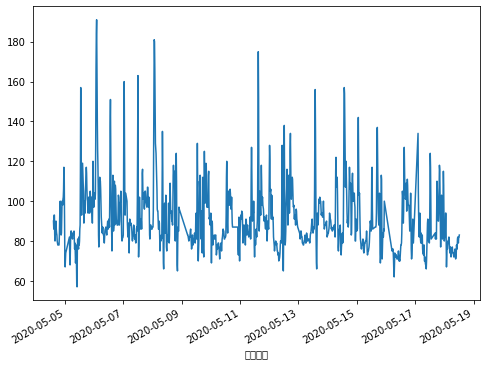

In [52]:
uni_data.plot(subplots=True)
#09년에서 16년 사이의 온도 변화를 보이는 그래프이다.

In [53]:
uni_data = uni_data.values

In [54]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [55]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [90]:
#마지막 20개의 혈당기록을 데이터로 가지고 다음 혈당수치 예측하기
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target-1)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [91]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target glucose to predict')
print (y_train_uni[0])

Single window of past history
[[-0.17183098]
 [-0.40455917]
 [ 0.00271516]
 [ 0.00271516]
 [-0.57910532]
 [-0.75365146]
 [-0.57910532]
 [-0.34637713]
 [-0.17183098]
 [-0.40455917]
 [-0.52092327]
 [-0.57910532]
 [-0.75365146]
 [-0.81183351]
 [-0.87001556]
 [-0.87001556]
 [-0.87001556]
 [-0.87001556]
 [-0.87001556]
 [-0.63728737]]

 Target glucose to predict
-0.6372873660850756


In [92]:
#데이터 생성되었으므로 예측값 확인
def create_time_steps(length):
  return list(range(-length, 0))


In [93]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\qkrtm\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

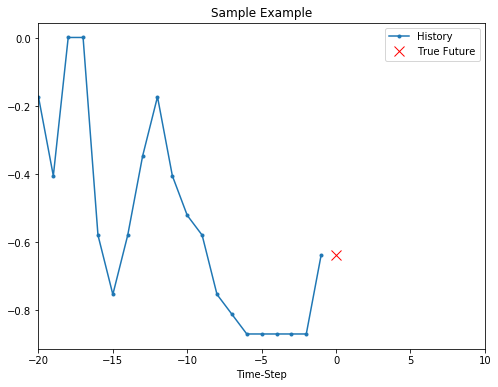

In [94]:
#올바른 예측 정답 값은 빨간 X
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [95]:
#베이스라인 = 입력지점 주어지면, 모든 기록의 다음 예측은 
#최근 20개의 관측치 평균으로 예측할 것(학습)

In [96]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\qkrtm\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

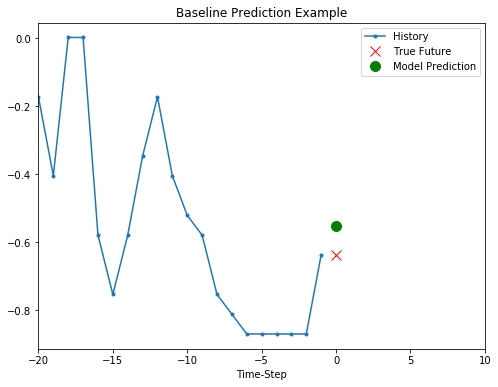

In [97]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [98]:
#모델의 예측값이 정답 Y라벨을 생각보다 가깝게 잡아냄 혈당값만 가지고 예측한 상황

In [99]:
#이제 RNN사용
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [100]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [101]:
#옵티마이저는 아담, 손실함수는 mean abs를 사용

In [102]:
#모델 출력 확인을 위해 샘플 예측
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [103]:
#모델 훈련 시키기 simple lstm 모델
EVALUATION_INTERVAL = 200
EPOCHS = 10

#simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                   #   steps_per_epoch=EVALUATION_INTERVAL,
                    #  validation_data=val_univariate, validation_steps=50)
uni_history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 0.4558 - val_loss: 0.3656
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1561 - val_loss: 0.2933
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0589 - val_loss: 0.2957
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0430 - val_loss: 0.2966
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0362 - val_loss: 0.2970
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0307 - val_loss: 0.2969
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0269 - val_loss: 0.2971
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0243 - val_loss: 0.2973
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0221 - val_loss: 0.2975
Epoch 10/10
200/200 [===========================

In [104]:
#훈련 loss 는 0.0185, val loss 는 0.2974로 줄였다.
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

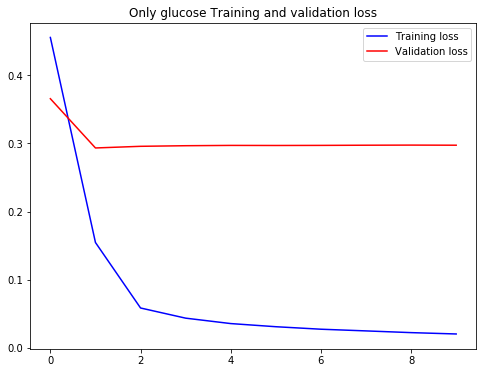

In [105]:
plot_train_history(uni_history,
                   'Only glucose Training and validation loss')

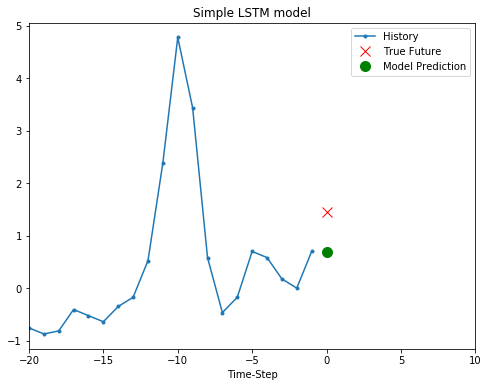

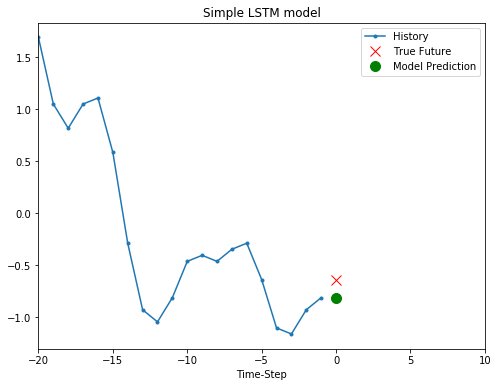

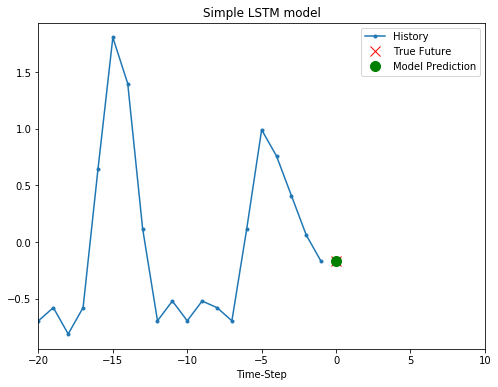

In [106]:
# 이 simple lstm 학습모델을 가지고 예측 시도
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [48]:
#UNI VARIATE 즉 혈당 값만으로 혈당값을 예측하는 것이기에 생각보다 잘 맞춘다.
#다변량 시계열 에측
#나중에 혈당값 말고도 인슐린 농도 등의 데이터를 고려할 수 도 있으므로
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [49]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5A83F9208>,
      dtype=object)

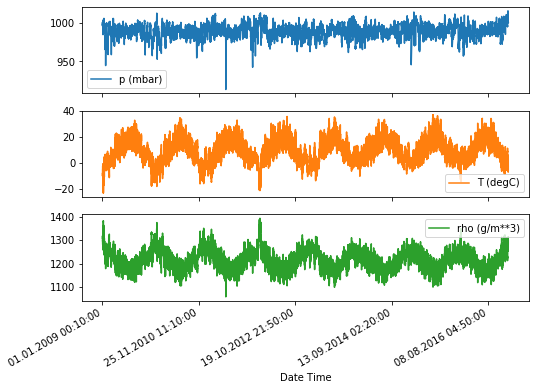

In [50]:
features.plot(subplots=True)

In [51]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [52]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [53]:
#720개(5일 * 6개(시간당)* 24시간(1일))
#예측 레이블 (12*6 즉 미래 12시간의 온도 예측)
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [54]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [55]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [56]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [57]:
#옵티마이저는 rmsprop으로 변경
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [58]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 72s 361ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 79s 393ms/step - loss: 0.2624 - val_loss: 0.2434
Epoch 3/10
200/200 [==============================] - 96s 482ms/step - loss: 0.2613 - val_loss: 0.2466
Epoch 4/10
200/200 [==============================] - 119s 593ms/step - loss: 0.2565 - val_loss: 0.2448
Epoch 5/10
200/200 [==============================] - 137s 684ms/step - loss: 0.2265 - val_loss: 0.2352
Epoch 6/10
200/200 [==============================] - 159s 796ms/step - loss: 0.2416 - val_loss: 0.2607
Epoch 7/10
200/200 [==============================] - 169s 846ms/step - loss: 0.2411 - val_loss: 0.2553
Epoch 8/10
200/200 [==============================] - 172s 859ms/step - loss: 0.2408 - val_loss: 0.2366
Epoch 9/10
200/200 [==============================] - 180s 901ms/step - loss: 0.2449 - val_loss: 0.2466
Epoch 10/10
200/200 [===

In [59]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

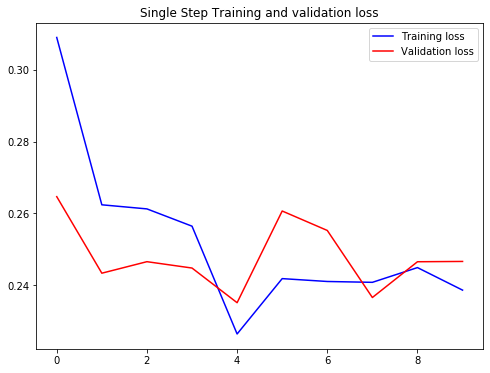

In [60]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

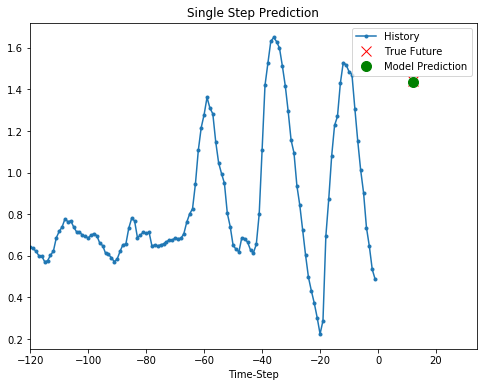

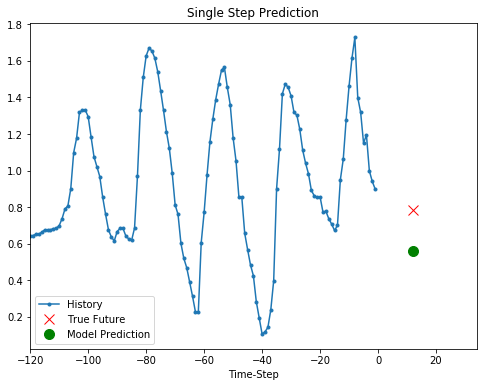

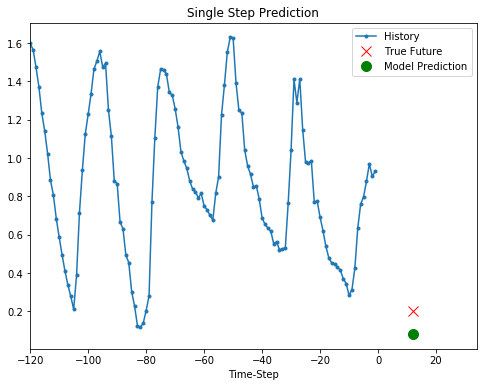

In [61]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [62]:
#과거 데이터를 가지고 미래 값을 예측
#12시간의 미래 온도를예측 총 72개 예측 데이터 생성
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [63]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [64]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [65]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

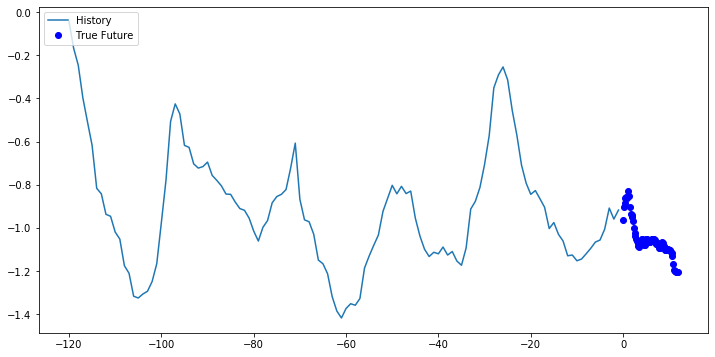

In [66]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))
#정답인 Y레이블을 파란 점으로 표현

In [67]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [68]:
#좀더 DEEP한 2개 LAYER 사용, 72개 예측값 출력
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)
#우선 SHAPE을 출력

(256, 72)


In [69]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
#학습을 시켜본다.

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 255s 1s/step - loss: 0.4964 - val_loss: 0.3027
Epoch 2/10
200/200 [==============================] - 281s 1s/step - loss: 0.3465 - val_loss: 0.2833
Epoch 3/10
200/200 [==============================] - 321s 2s/step - loss: 0.3275 - val_loss: 0.2407
Epoch 4/10
200/200 [==============================] - 361s 2s/step - loss: 0.2411 - val_loss: 0.2065
Epoch 5/10
200/200 [==============================] - 401s 2s/step - loss: 0.1975 - val_loss: 0.1980
Epoch 6/10
200/200 [==============================] - 453s 2s/step - loss: 0.2060 - val_loss: 0.2072
Epoch 7/10
200/200 [==============================] - 457s 2s/step - loss: 0.1980 - val_loss: 0.2083
Epoch 8/10
200/200 [==============================] - 336s 2s/step - loss: 0.1958 - val_loss: 0.1904
Epoch 9/10
200/200 [==============================] - 306s 2s/step - loss: 0.1971 - val_loss: 0.1858
Epoch 10/10
200/200 [===========================

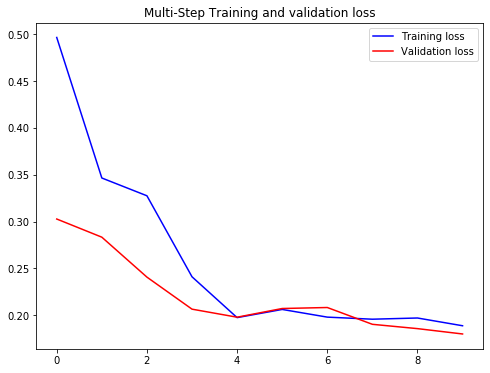

In [70]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

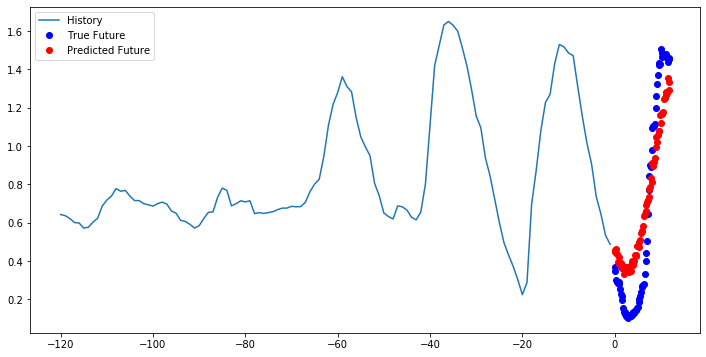

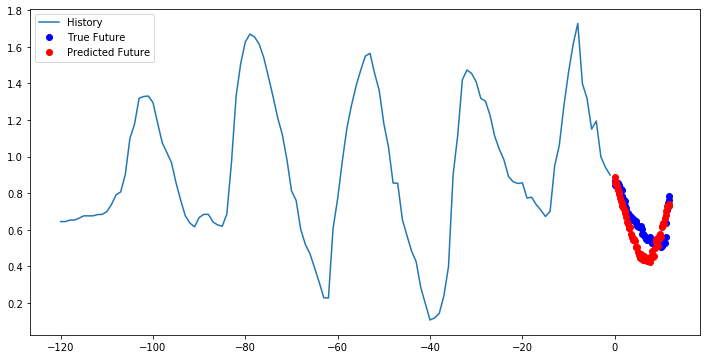

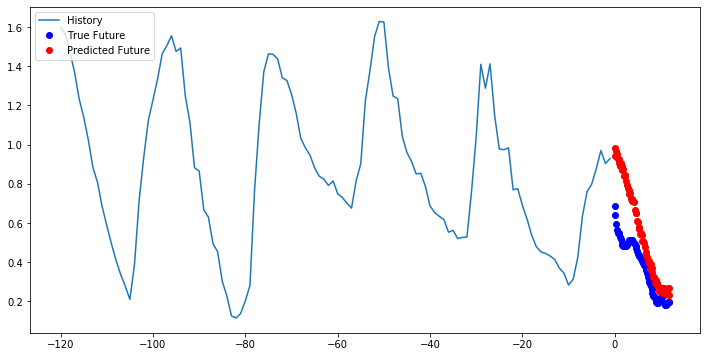

In [71]:
#학습된 네트워크가 미래예측을 잘 배웠는지 확인
#빨간 점이 예측값, 파란점이 실제 Y라벨
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])